# Multi-label Legal Text Classification for CIA

## Models and Experiments: Baseline Models

In [ ]:
!pip install umap-learn

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv

In [196]:
from zipfile import ZipFile
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
import gensim.downloader as api
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from nltk.tokenize import sent_tokenize, word_tokenize
from numpy.linalg import norm
import umap.umap_ as umap

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
import pickle

In [7]:
os.chdir("../..")
os.getcwd()

'/Users/janinedevera/Documents/School/MDS 2021-2023/Thesis/multilabel-legal-text-classification-CIA'

### Preliminaries

Load data

In [8]:
text = pd.read_csv("data/01 legal_texts_pipeline_stopwords.csv", index_col=0)
text_labels = pd.read_csv("data/01 legal_texts_with_labels_grouped.csv", index_col=0)
defs = pd.read_csv("data/02 oecd_definitions_stopwords.csv", index_col=0)
defs_grouped = pd.read_csv("data/02 oecd_definitions_stopwords_grouped.csv", index_col=0)

In [12]:
defs_grouped['Main'] = defs_grouped['Main'].replace('D', 'Others')
defs_grouped

,Main,text_clean,length
0,A,limit the number of supplier lead to the risk ...,833
1,B,regul can affect a supplier 's abil to compet ...,781
2,C,regul can affect supplier behaviour by not onl...,459
3,Others,regul sometim limit choic avail to consum for ...,257


Clean labels

In [163]:
text_labels.Category_New.value_counts()

A         772
None      663
B         115
Others     44
C          29
Name: Category_New, dtype: int64

### I. Logistic Regression

##### a. TF-IDF

As the first baseline model, check the performance of a logistic regression using the **TF-IDF matrix** of the corpus.

In [187]:
# tf-idf vectorizer
vectorizer = TfidfVectorizer()
dfm = vectorizer.fit_transform(text_labels['text_clean'])
dfm.shape

(1623, 2597)

In [188]:
# split data
l_train_text, l_test_text, l_train_labels, l_test_labels = train_test_split(dfm, text_labels['Category_New'], 
                                                                            random_state=999, 
                                                                            test_size=0.3, 
                                                                            stratify=text_labels['Category_New'])

In [189]:
# train model and return training accuracy
clf = LogisticRegression(random_state=999).fit(l_train_text, l_train_labels)
with open('./models/logistic.pkl', 'wb') as f: pickle.dump(clf, f)

train_acc = clf.score(l_train_text, l_train_labels)

# evaluate on test data 
y_pred = clf.predict(l_test_text)
classification_rep = classification_report(l_test_labels, y_pred, zero_division=0)
test_acc = clf.score(l_test_text, l_test_labels)

# print classification report
print(' Classification Report:')
print(classification_rep)
print('Train vs Test Accuracy:')
print('Train:' + str(round(train_acc, 3)))
print('Test:' + str(round(test_acc, 3)))

 Classification Report:
              precision    recall  f1-score   support

           A       0.84      0.95      0.89       232
           B       0.80      0.24      0.36        34
           C       0.00      0.00      0.00         9
        None       0.88      0.95      0.91       199
      Others       0.00      0.00      0.00        13

    accuracy                           0.86       487
   macro avg       0.50      0.43      0.43       487
weighted avg       0.82      0.86      0.82       487

Train vs Test Accuracy:
Train:0.899
Test:0.858


##### b. Bi-grams TF-IDF

This is also compared with a logistic regression using a **tri-gram TF-IDF matrix**, which gives all the possible combinations of 3 words. 

In [373]:
word_vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', sublinear_tf=True, strip_accents='unicode', 
                                  stop_words='english', ngram_range=(2, 2))

dfm_tri = word_vectorizer.fit_transform(text_labels['text_clean'])
dfm_tri.shape

(1623, 16978)

In [374]:
l_train_text, l_test_text, l_train_labels, l_test_labels = train_test_split(dfm_tri, text_labels['Category_New'], 
                                                                            random_state=999, 
                                                                            test_size=0.3, 
                                                                            stratify=text_labels['Category_New'])

In [375]:
# train model and return training accuracy
clf = LogisticRegression(random_state=999).fit(l_train_text, l_train_labels)
with open('./models/logistic.spkl', 'wb') as f: pickle.dump(clf, f)

train_acc = clf.score(l_train_text, l_train_labels)

# evaluate on test data 
y_pred = clf.predict(l_test_text)
classification_rep = classification_report(l_test_labels, y_pred, zero_division=0)
test_acc = clf.score(l_test_text, l_test_labels)

# print classification report
print(' Classification Report:')
print(classification_rep)
print('Train vs Test Accuracy:')
print('Train:' + str(round(train_acc, 3)))
print('Test:' + str(round(test_acc, 3)))

# get feature names from vocabulary of vectorizer
feature_names = word_vectorizer.get_feature_names_out()

# calculate feature importance
importance = clf.coef_[0]
feature_importance = abs(importance)
sorted_idx = feature_importance.argsort()[::-1]

# print top 20 important features (tri-grams)
print('Top 20 Important Tri-grams:')
for i, idx in enumerate(sorted_idx[:20]):
    print(f"{i+1}. Tri-gram: {feature_names[idx]}, Importance: {feature_importance[idx]}")

 Classification Report:
              precision    recall  f1-score   support

           A       0.86      0.84      0.85       232
           B       0.00      0.00      0.00        34
           C       0.00      0.00      0.00         9
        None       0.76      0.99      0.86       199
      Others       0.00      0.00      0.00        13

    accuracy                           0.81       487
   macro avg       0.32      0.37      0.34       487
weighted avg       0.72      0.81      0.76       487

Train vs Test Accuracy:
Train:0.898
Test:0.807
Top 20 Important Tri-grams:
1. Tri-gram: perform guarante, Importance: 1.373120798353981
2. Tri-gram: aviat fuel, Importance: 1.2111755864932068
3. Tri-gram: approv anac, Importance: 1.1500558052090526
4. Tri-gram: port worker, Importance: 0.9592305478454392
5. Tri-gram: thi articl, Importance: 0.9415626642945814
6. Tri-gram: ship compani, Importance: 0.9365260799029799
7. Tri-gram: thi resolut, Importance: 0.9081737376702644
8. Tri-gra

Performance of TF-IDF and tri-gram TF-IDF models do not vary significantly. Training accuracy is at around 90% while testing accuracy is at around 86%. In most categories (with meaningful number of observations) recall is higher than precision, which means that the model performs better on minimizing false negatives than false positives.

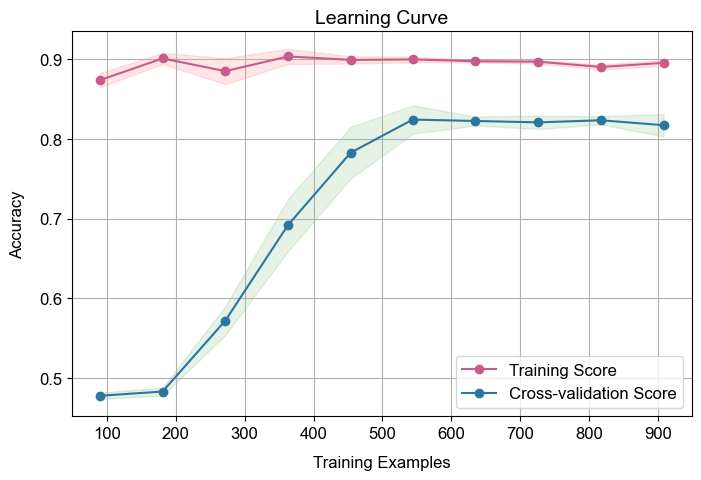

In [376]:
# function for learning curve
def plot_learning_curve(estimator, X, y, cv, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.title('Learning Curve', fontname='Arial', fontsize=14)
    plt.xlabel('Training Examples', fontname= 'Arial', fontsize=12, labelpad=10)
    plt.ylabel('Accuracy', fontname='Arial', fontsize=12, labelpad=10)
    plt.xticks(fontname='Arial', fontsize=12)
    plt.yticks(fontname='Arial', fontsize=12)

    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='#C85B89',
             label='Training Score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='#2A769E',
             label='Cross-validation Score')
    plt.legend(loc='best', prop={'family': 'Arial', 'size': 12})
    plt.show()

# plot learning curve
plot_learning_curve(clf, l_train_text, l_train_labels, cv=5)


However, the learning curves show that the training accuracy is consistently higher than the test accuracy, with the latter showing no furter improvement despite the increase in number of observations. This could be an indication that the model is overfitting to the training data. The small dataset also makes it more likely that the model is overfitting.

### II. GloVe

As an alternative, pre-trained word embeddings can be used to represent the corpus by averaging word vectors using the TF-IDF matrix. From here, similarity scores are obtained between legal texts and the definitions of 4 competition restrictions.

##### a. Document embedding matrix

In [211]:
# load GloVe embeddings
dims = 300
f = open(f'data/glove/glove.6B.{dims}d.txt') # download GloVe and save in data folder

embed_matrix = pd.read_table(
    f, sep = " ", index_col = 0, 
    header = None, quoting = csv.QUOTE_NONE
)

embed_matrix.shape

(400000, 300)

In [212]:
# function for doc embeddings
def doc_embed(df, vectorizer):
    dfm = vectorizer.fit_transform(df['text_clean'])
    common_features = set(embed_matrix.index) & set(vectorizer.get_feature_names_out())
    vocab_ids = [vectorizer.vocabulary_[x] for x in common_features]
    matrix = dfm[:,vocab_ids].dot(embed_matrix.loc[common_features,])
    return matrix

In [213]:
vectorizer = TfidfVectorizer()

In [214]:
# doc embeddings for legal text
text_labels_embed = doc_embed(text_labels, vectorizer)
text_labels_embed.shape

/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_21658/2389357900.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  matrix = dfm[:,vocab_ids].dot(embed_matrix.loc[common_features,])


(1623, 300)

In [215]:
# doc embeddings for grouped labels
defs_grouped_embed = doc_embed(defs_grouped, vectorizer)
defs_grouped_embed.shape

/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_21658/2389357900.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  matrix = dfm[:,vocab_ids].dot(embed_matrix.loc[common_features,])


(4, 300)

##### b. Cosine similarities

In [218]:
def cos_sim(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

In [219]:
docs = []
for i in range(len(text_labels_embed)):
    scores = []
    for j in range(len(defs_grouped_embed)):
        A = text_labels_embed[i]
        B = defs_grouped_embed[j]
        scores += [(cos_sim(A,B)+1)/(1+1)] # centered 
    docs += [scores]

In [223]:
scores_df = pd.DataFrame(docs, columns = ["A", "B", "C", "Others"])
scores_df.head()

,A,B,C,Others
0,0.901425,0.892006,0.893792,0.898795
1,0.901425,0.892006,0.893792,0.898795
2,0.927095,0.921130,0.915149,0.913062
3,0.969802,0.963933,0.958205,0.957638
4,0.973000,0.971173,0.966005,0.967465


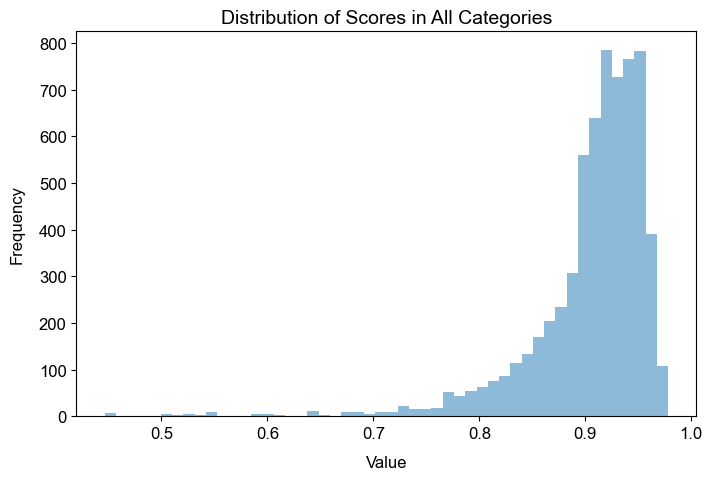

In [246]:
plt.figure(figsize=(8, 5))
plt.hist(scores_df.values.flatten(), bins=50, alpha=0.5, fill='#0C6291')
plt.xlabel('Value', fontname='Arial', fontsize=12, labelpad=10)
plt.ylabel('Frequency', fontname='Arial', fontsize=12, labelpad=10)
plt.title('Distribution of Scores in All Categories', fontname='Arial', fontsize=14)
plt.xticks(fontname='Arial', fontsize=12)
plt.yticks(fontname='Arial', fontsize=12)
plt.show()

In [247]:
# df with scores
text_scores_labels_glove = pd.merge(text_labels, scores_df, left_index=True, right_index=True)
text_scores_labels_glove.to_csv("data/scores/01 sim_scores_glove_labeled.csv")

##### c. Threshold test

In [92]:
text_scores_labels_glove = pd.read_csv("data/scores/01 sim_scores_glove_labeled.csv", index_col=0)

In [248]:
df_long = pd.melt(text_scores_labels_glove, id_vars=['Law', 'Text', 'Category',  'Category_New', 'text_clean'], 
                  var_name='Predict_Label', value_name='Score') #scores df to long format 
df_long.head()

,Law,Text,Category,Category_New,text_clean,Predict_Label,Score
0,Resolution 153/2010 by National Civil Aviation...,If any competent body on the matter imposes mo...,A,A,if ani compet bodi on the matter impos modif o...,A,0.901425
1,Resolution 153/2010 by National Civil Aviation...,If any competent body on the matter imposes mo...,Administrativeburden,Others,if ani compet bodi on the matter impos modif o...,A,0.901425
2,Ministerial Ordinance 93/2020 by Ministry of I...,The National Civil Aviation Secretary must aut...,A,A,the nation civil aviat secretari must authoris...,A,0.927095
3,Ministerial Ordinance 93/2020 by Ministry of I...,The commercial contract which involves the use...,A,A,the commerci contract which involv the use of ...,A,0.969802
4,Ministerial Ordinance 93/2020 by Ministry of I...,The National Civil Aviation Secretary may auth...,A,A,the nation civil aviat secretari may authoris ...,A,0.973000


Since the distribution of the scores is skewed to the right, the threshold also has to be set high.

In [281]:
results_multiclass = df_long 
results_multiclass['Predict'] = np.where(results_multiclass['Score'] > 0.90, results_multiclass['Predict_Label'], 'None') #set threshold
results_multiclass[['Law', 'Text', 'text_clean', 'Score', 'Category_New', 'Predict']].drop_duplicates()

The similarity method using GloVe embeddings does not perform as well as the logistic regression.

In [283]:
report = classification_report(results_multiclass['Category_New'], results_multiclass['Predict'])
print(report)

              precision    recall  f1-score   support

           A       0.47      0.18      0.26      3088
           B       0.08      0.18      0.11       460
           C       0.02      0.17      0.03       116
        None       0.40      0.32      0.35      2652
      Others       0.03      0.16      0.05       176

    accuracy                           0.23      6492
   macro avg       0.20      0.20      0.16      6492
weighted avg       0.39      0.23      0.28      6492



##### d. Binary threshold test

All categories can also be grouped as "Yes" (i.e. with potential restrictions) to test if the similarity method performs better if applied to a binary classification task. 

In [278]:
results_binary = df_long 
results_max_score = results_binary.groupby('Text')['Score'].max() #get the highest score among 4 categories
results_final = pd.merge(results_binary, results_max_score, on=['Text', 'Score'])

results_final['Predict'] = np.where(results_final['Score'] > 0.90, 'Yes', 'None') #if max score of highest category is above 0.95, predicted label = yes
results_final['Category_New'] = np.where(results_final['Category_New'] == 'None', results_final['Category_New'], 'Yes') #all categories changed to 'yes' except none

In [279]:
report = classification_report(results_final['Category_New'], results_final['Predict'])
print(report)

              precision    recall  f1-score   support

        None       0.41      0.27      0.32       663
         Yes       0.59      0.73      0.65       960

    accuracy                           0.54      1623
   macro avg       0.50      0.50      0.49      1623
weighted avg       0.52      0.54      0.52      1623



As a binary classification problem, the similarity method performs slightly better. Recall is high for the Yes category, but overall accuracy is only at 54%.

##### e. Dimensionality reduction

In [292]:
# df combining text and labels
df_comb = (text_scores_labels_glove[['Law', 'text_clean', 'Category_New']]
           .rename(columns = {'Law':'name'})
           .append(defs_grouped[['Main', 'text_clean']]
                   .rename(columns = {'Main':'name'})))
df_comb.head()

/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_21658/1632365060.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_comb = (text_scores_labels_glove[['Law', 'text_clean', 'Category_New']]


,name,text_clean,Category_New
0,Resolution 153/2010 by National Civil Aviation...,if ani compet bodi on the matter impos modif o...,A
1,Resolution 153/2010 by National Civil Aviation...,if ani compet bodi on the matter impos modif o...,Others
2,Ministerial Ordinance 93/2020 by Ministry of I...,the nation civil aviat secretari must authoris...,A
3,Ministerial Ordinance 93/2020 by Ministry of I...,the commerci contract which involv the use of ...,A
4,Ministerial Ordinance 93/2020 by Ministry of I...,the nation civil aviat secretari may authoris ...,A


In [293]:
reducer = umap.UMAP()

# dfm combining embeddings 
def dfm_combined(df, dfm1, dfm2):
    dfm_comb = np.vstack((dfm1, dfm2))
    embed = reducer.fit_transform(dfm_comb)
    df["x"] = embed[:,0]
    df["y"] = embed[:,1]
    return df

In [297]:
dfm_reduced = dfm_combined(df_comb, text_labels_embed, defs_grouped_embed)

In [299]:
dfm_reduced.to_csv("data/scores/02 sim_scores_dim_reduced_glove.csv")

### II. Legal Word2Vec

The same method as GloVe similarity scores is applied but using Word2Vec embeddings trained from a legal corpus. 

##### a. Document embedding matrix (from SigmaLaw word2vec trained from legal corpus)

In [304]:
w2v_law = KeyedVectors.load_word2vec_format("data/sigma-lemmatized-legal/legallemmatextreplacewithnnp.bin", binary=True, unicode_errors='ignore') 
w2v_law.vectors.shape

(52431, 200)

In [305]:
def doc_matrix_w2v(dfm):
    words = set(vectorizer.get_feature_names_out())
    text_vocab = list(words)

    common_features = []
    for word in text_vocab:
        if word in w2v_law:
            common_features += [word]

    embed_common=np.empty((0,200))
    for word in words:
        if word in w2v_law:
            embed_common=np.vstack([embed_common, w2v_law[word]])

    vocab_ids = [vectorizer.vocabulary_[x] for x in common_features]
    doc_matrix_w2v = dfm[:,vocab_ids].dot(embed_common)

    return doc_matrix_w2v
    

In [306]:
text_dfm = vectorizer.fit_transform(text_labels['text_clean'])
text_doc_matrix = doc_matrix_w2v(text_dfm)
text_doc_matrix.shape

(1623, 200)

In [307]:
defs_dfm = vectorizer.fit_transform(defs_grouped['text_clean'])
defs_doc_matrix = doc_matrix_w2v(defs_dfm)
defs_doc_matrix.shape

(4, 200)

##### b. Cosine similarities

In [308]:
docs = []
for i in range(len(text_doc_matrix)):
    scores = []
    for j in range(len(defs_doc_matrix)):
        A = text_doc_matrix[i]
        B = defs_doc_matrix[j]
        scores += [(cos_sim(A,B)+1)/(1+1)] # centered 
    docs += [scores]

In [312]:
scores_df = pd.DataFrame(docs, columns = ["A", "B", "C", "Others"])
scores_df.head()

,A,B,C,Others
0,0.656170,0.612072,0.614056,0.617290
1,0.656170,0.612072,0.614056,0.617290
2,0.639391,0.643102,0.636944,0.621967
3,0.724994,0.726468,0.692108,0.690039
4,0.732268,0.733423,0.728037,0.699579


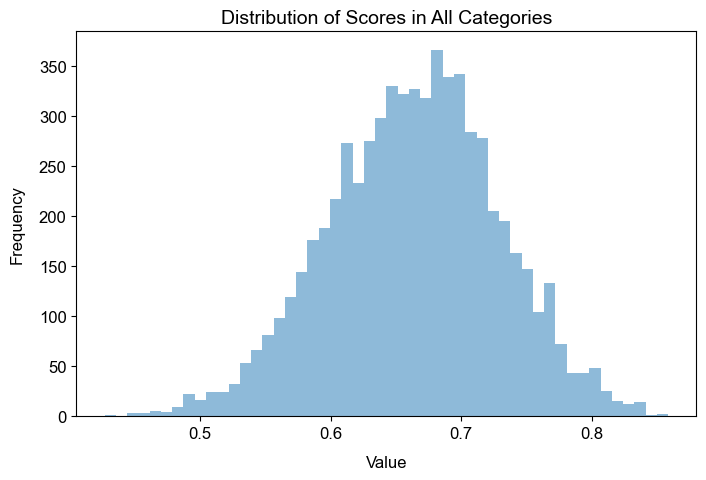

In [313]:
plt.figure(figsize=(8, 5))
plt.hist(scores_df.values.flatten(), bins=50, alpha=0.5, fill='#0C6291')
plt.xlabel('Value', fontname='Arial', fontsize=12, labelpad=10)
plt.ylabel('Frequency', fontname='Arial', fontsize=12, labelpad=10)
plt.title('Distribution of Scores in All Categories', fontname='Arial', fontsize=14)
plt.xticks(fontname='Arial', fontsize=12)
plt.yticks(fontname='Arial', fontsize=12)
plt.show()

In [314]:
# df with scores
text_scores_legalw2v = pd.merge(text_labels, scores_df, left_index=True, right_index=True)
text_scores_legalw2v.to_csv("data/scores/01 sim_scores_legalw2v_labeled.csv")

##### c. Threshold test

In [317]:
df_long = pd.melt(text_scores_legalw2v, id_vars=['Law', 'Text', 'Category',  'Category_New', 'text_clean'], 
                  var_name='Predict_Label', value_name='Score') #scores df to long format 
df_long.head()

,Law,Text,Category,Category_New,text_clean,Predict_Label,Score
0,Resolution 153/2010 by National Civil Aviation...,If any competent body on the matter imposes mo...,A,A,if ani compet bodi on the matter impos modif o...,A,0.656170
1,Resolution 153/2010 by National Civil Aviation...,If any competent body on the matter imposes mo...,Administrativeburden,Others,if ani compet bodi on the matter impos modif o...,A,0.656170
2,Ministerial Ordinance 93/2020 by Ministry of I...,The National Civil Aviation Secretary must aut...,A,A,the nation civil aviat secretari must authoris...,A,0.639391
3,Ministerial Ordinance 93/2020 by Ministry of I...,The commercial contract which involves the use...,A,A,the commerci contract which involv the use of ...,A,0.724994
4,Ministerial Ordinance 93/2020 by Ministry of I...,The National Civil Aviation Secretary may auth...,A,A,the nation civil aviat secretari may authoris ...,A,0.732268


The similarity scores based on the Legalw2v embeddings approximate normal distribution so threshold score is set lower than GloVe.

In [346]:
results_multiclass = df_long 
results_multiclass['Predict'] = np.where(results_multiclass['Score'] > 0.65, results_multiclass['Predict_Label'], 'None') #set threshold
results_multiclass[['Law', 'Text', 'text_clean', 'Score', 'Category_New', 'Predict']].drop_duplicates()

,Law,Text,text_clean,Score,Category_New,Predict
0,Resolution 153/2010 by National Civil Aviation...,If any competent body on the matter imposes mo...,if ani compet bodi on the matter impos modif o...,0.656170,A,A
1,Resolution 153/2010 by National Civil Aviation...,If any competent body on the matter imposes mo...,if ani compet bodi on the matter impos modif o...,0.656170,Others,A
2,Ministerial Ordinance 93/2020 by Ministry of I...,The National Civil Aviation Secretary must aut...,the nation civil aviat secretari must authoris...,0.639391,A,None
3,Ministerial Ordinance 93/2020 by Ministry of I...,The commercial contract which involves the use...,the commerci contract which involv the use of ...,0.724994,A,A
4,Ministerial Ordinance 93/2020 by Ministry of I...,The National Civil Aviation Secretary may auth...,the nation civil aviat secretari may authoris ...,0.732268,A,A
...,...,...,...,...,...,...
6487,Ley de Desarrollo Rural Sustentable DOF 12-01-...,The Inter-Ministerial Commision for Sustainabl...,the inter-ministeri commis for sustain rural d...,0.705084,C,Others
6488,Ley Federal de Responsabilidad Ambiental DOF 0...,The Ministry of Environment and Natural Resour...,the ministri of environ and natur resourc will...,0.586234,B,None
6489,"NOM-009-Z00-1994, Proceso sanitario de la came",The regulation deals with the sanitary procesi...,the regul deal with the sanitari procesisng of...,0.669517,B,Others
6490,Ley Federal de Proteccion al Consumidor,The Federal Attorney's Office of the Consumer ...,the feder attorney 's offic of the consum prod...,0.660974,B,Others


In [347]:
report = classification_report(results_multiclass['Category_New'], results_multiclass['Predict'])
print(report)

              precision    recall  f1-score   support

           A       0.47      0.16      0.24      3088
           B       0.09      0.20      0.13       460
           C       0.02      0.13      0.03       116
        None       0.43      0.43      0.43      2652
      Others       0.03      0.15      0.05       176

    accuracy                           0.27      6492
   macro avg       0.21      0.21      0.18      6492
weighted avg       0.41      0.27      0.30      6492



##### d. Binary threshold test

In [344]:
results_binary = df_long 
results_max_score = results_binary.groupby('Text')['Score'].max() #get the highest score among 4 categories
results_final = pd.merge(results_binary, results_max_score, on=['Text', 'Score'])

results_final['Predict'] = np.where(results_final['Score'] > 0.65, 'Yes', 'None') #if max score of highest category is above 0.95, predicted label = yes
results_final['Category_New'] = np.where(results_final['Category_New'] == 'None', results_final['Category_New'], 'Yes') #all categories changed to 'yes' except none

In [345]:
report = classification_report(results_final['Category_New'], results_final['Predict'])
print(report)

              precision    recall  f1-score   support

        None       0.44      0.26      0.32       663
         Yes       0.60      0.77      0.68       960

    accuracy                           0.56      1623
   macro avg       0.52      0.51      0.50      1623
weighted avg       0.53      0.56      0.53      1623



Based on the results of both the Glove and LegalW2V similarity tests, it appears pre-trained embeddings are able to more or less distinguish whether a certain paragraph is similar to a competition restriction definition. However, the embeddings are unable to capture the difference among the four categories.

##### e. Dimensionality reduction

In [351]:
dfm_reduced = dfm_combined(df_comb, text_doc_matrix, defs_doc_matrix)

In [352]:
dfm_reduced.to_csv("data/scores/02 sim_scores_dim_reduced_legal.csv")